In [1]:
import os
import time
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol
import glob
import matplotlib.pyplot as plt

In [ ]:
def read_sdfs(sdf_pattern):
    """Read SDF files and return a list of molecules."""
    sdf_files = glob.glob(sdf_pattern)
    mols = []
    filenames = []
    for sdf_file in sdf_files:
        suppl = Chem.SDMolSupplier(sdf_file)
        for mol in suppl:
            if mol is not None:
                mols.append(mol)
                filenames.append(os.path.splitext(os.path.basename(sdf_file))[0])
    return mols, filenames

def draw_molecules(mols, img_file_name,filenames):
    """Draw a grid of molecules and save to an image file."""
    mols_per_row = 7  # Set how many molecules per row in the grid
    fig, axs = plt.subplots(len(mols) // mols_per_row + 1, mols_per_row, figsize=(20, 20))
    axs = axs.flatten()
    
    for i, (mol, filename) in enumerate(zip(mols,filenames)):
        img = Draw.MolToImage(mol, size=(300, 300))
        axs[i].set_title(filename)
        axs[i].imshow(img)
        axs[i].axis('off')  # Hide the axes
    
        # Hide unused subplots
        for ax in axs[i+1:]:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(img_file_name)
    plt.close()

In [ ]:
# drawing a mol grid
if __name__ == "__main__":
    # Adjust the pattern to match your SDF files location and pattern
    molecules, filenames = read_sdfs('./Docking\ Analysis/Ligands/sdf/*.sdf')
    draw_molecules(molecules, 'molecules_grid.png',filenames)

loading data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

In [3]:
# loading dG data
df_dg_autodock = pd.read_csv('./data/AutoDock_WOW/dG.csv')
df_dg_flare = pd.read_csv('./data/Flare_WOW/dG.csv')
df_dg_rdock = pd.read_csv('./data/rDock/dG.csv')


In [4]:
# shape for each dataframe
print(df_dg_autodock.shape)
print(df_dg_flare.shape)
print(df_dg_rdock.shape)

(1088, 7)
(428, 5)
(501, 6)


In [5]:
def filter_data(df):
    '''Filter dG data'''

    # Convert 'dG' column to numeric in each dataframe and handle non-numeric values
    df['dG'] = pd.to_numeric(df['dG'], errors='coerce')
    # Fill NaN values with a number that makes sense in your context, for example, 0
    df['dG'].fillna(0, inplace=True)
    # dropna
    df = df.dropna(subset=['dG'])
    df = df.dropna(subset=['Ligand_Name'])
    # cleaning up wrong ligand names, e.g. DAR should be DAR_DIR
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('DAR_DIR', 'DAR')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Forsythoside_E', 'Forsythoside')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Oryxylin_A', 'Oroxylin_A')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Quercitin', 'Quercetin')
    # dropping known bad ligands, e.g. 'Disulfiram'
    drop_list = ['Disulfiram', 'VTRRT', 'Diammonium', 'Scutellarein', 'Beta', 'Theaflavin_Digallate', 'Quercetin', 'Baicalein', 'Baicalin', 'NHC', 'Torvoside_H', 'Lopinavir']
    df = df[~df['Ligand_Name'].str.contains('|'.join(drop_list))] 
    
    # i only want site 1 data, so drop duplicates here.
    df = df.drop_duplicates(subset='Ligand_Name')
    # double checking...
    # df = df.loc[(df['Site_Number'] == 'Site1') & (df['RMSD Value'] == 0) & ((df['With_Or_Without_Water'] == 'WOW') | (df['With_Or_Without_Water'] == 'Without_Water'))]
    return df

In [6]:
# filtering dG data
df_dg_autodock = filter_data(df_dg_autodock)
df_dg_flare = filter_data(df_dg_flare)
df_dg_rdock = filter_data(df_dg_rdock)

In [7]:
# shape for each dataframe
print(df_dg_autodock.shape)
print(df_dg_flare.shape)
print(df_dg_rdock.shape)

(23, 7)
(23, 5)
(23, 6)


Heatmap for dG comparisons

In [8]:
# Add a new column to each dataframe to specify the software
df_dg_autodock['Software'] = 'AutoDock'
df_dg_flare['Software'] = 'Flare'
df_dg_rdock['Software'] = 'rDock'
# Concatenate the dataframes
df_all = pd.concat([df_dg_rdock, df_dg_autodock, df_dg_flare])
df_all = df_all.dropna(subset=['dG'])
df_all['dG'].fillna(0, inplace=True)

In [9]:
# # Sort the dataframes by 'dG' column and select the top 10 rows
df_all_top10 = df_all.sort_values(by='dG', ascending=False).head(10)
top10_lig_name = df_all_top10['Ligand_Name']
df_all_top10 = df_all[df_all['Ligand_Name'].isin(top10_lig_name)]

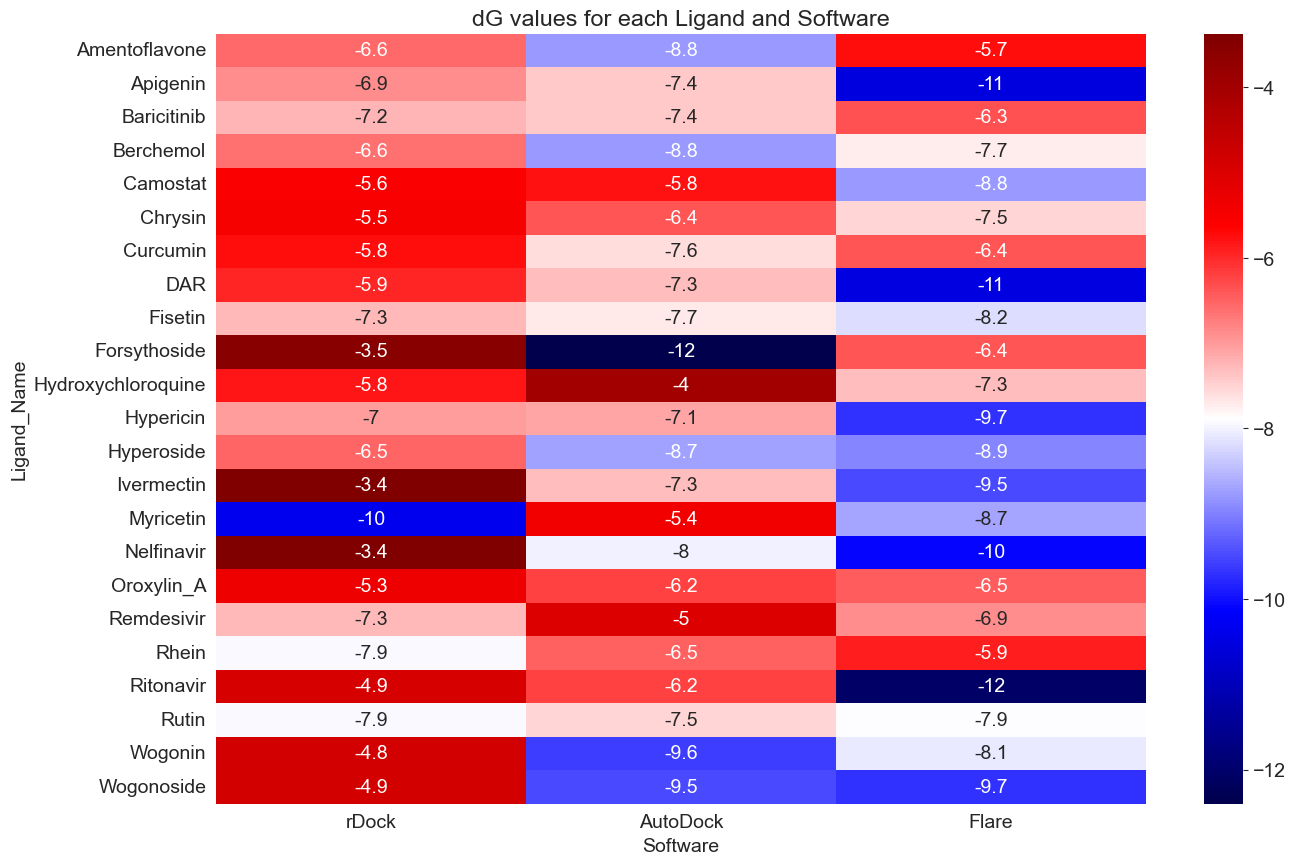

In [10]:
# Pivot the dataframe to get the desired format for the heatmap
df_pivot = df_all.pivot(index='Ligand_Name', columns='Software', values='dG')
# Drop the rows where all dG values are missing
df_pivot = df_pivot.dropna(how='all')
# Reorder the columns
df_pivot = df_pivot[['rDock', 'AutoDock', 'Flare']]

# Create the heatmap
plt.figure(figsize=(15, 10))
# Set the default font size
plt.rcParams.update({'font.size': 14})  # Adjust as needed
sns.heatmap(df_pivot, annot=True, cmap='seismic')
plt.title('dG values for each Ligand and Software')
plt.savefig('dG_heatmap.png')
plt.show()

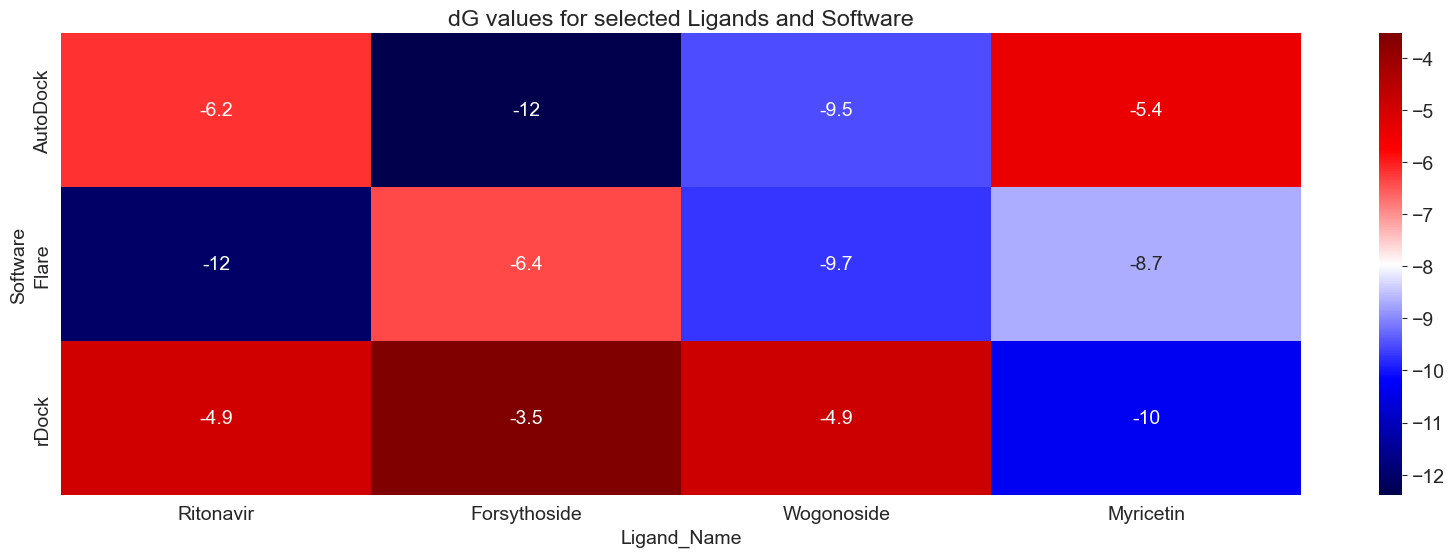

In [43]:
#draw a heatmap to show results for Ritonavir, Forsythoside, Wogonoside, and Myricetin
ligands = ['Ritonavir', 'Forsythoside', 'Wogonoside', 'Myricetin']

# Filter the DataFrame to only include the specified ligands
df_selected = df_all[df_all['Ligand_Name'].isin(ligands)]

# Pivot the DataFrame
df_pivot_selected = df_selected.pivot(index='Software', columns='Ligand_Name', values='dG')
# Reorder the columns
df_pivot_selected = df_pivot_selected[ligands]

# Create the heatmap
plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size': 14})
sns.heatmap(df_pivot_selected, annot=True, cmap='seismic')
plt.title('dG values for selected Ligands and Software')
plt.savefig('dG_heatmap_sele_lig.png')
plt.show()

Pearson's correlation (r) between dG results cross software

In [11]:
# shape for each dataframe
print(df_dg_autodock.shape)
print(df_dg_flare.shape)
print(df_dg_rdock.shape)

(23, 8)
(23, 6)
(23, 7)


In [12]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Compute Pearson's R
r_autodock_flare, _ = pearsonr(df_dg_autodock['dG'], df_dg_flare['dG'])
r_autodock_rdock, _ = pearsonr(df_dg_autodock['dG'], df_dg_rdock['dG'])
r_flare_rdock, _ = pearsonr(df_dg_flare['dG'], df_dg_rdock['dG'])

print(f"Pearson's R between AutoDock and Flare: {r_autodock_flare}")
print(f"Pearson's R between AutoDock and rDock: {r_autodock_rdock}")
print(f"Pearson's R between Flare and rDock: {r_flare_rdock}")

Pearson's R between AutoDock and Flare: -0.07043977698862046
Pearson's R between AutoDock and rDock: -0.402587142630647
Pearson's R between Flare and rDock: -0.2051175809314156


In [13]:
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

# Check if data is normally distributed
_, p_autodock = stats.shapiro(df_dg_autodock['dG'])
_, p_flare = stats.shapiro(df_dg_flare['dG'])
_, p_rdock = stats.shapiro(df_dg_rdock['dG'])

print(f"Autodock p-value: {p_autodock}")
print(f"Flare p-value: {p_flare}")
print(f"rDock p-value: {p_rdock}")

# If p-value is > 0.05, data is normally distributed
if p_autodock > 0.05 and p_flare > 0.05 and p_rdock > 0.05:
    # Perform ANOVA
    _, p_value = stats.f_oneway(df_dg_autodock['dG'], df_dg_flare['dG'], df_dg_rdock['dG'])
    print(f"ANOVA p-value: {p_value}")
    
    # Compute independent t-test
    t_autodock_flare, p_autodock_flare = ttest_ind(df_dg_autodock['dG'], df_dg_flare['dG'])
    t_autodock_rdock, p_autodock_rdock = ttest_ind(df_dg_autodock['dG'], df_dg_rdock['dG'])
    t_flare_rdock, p_flare_rdock = ttest_ind(df_dg_flare['dG'], df_dg_rdock['dG'])
    
    print(f"Independent t-test between AutoDock and Flare: t = {t_autodock_flare}, p = {p_autodock_flare}")
    print(f"Independent t-test between AutoDock and rDock: t = {t_autodock_rdock}, p = {p_autodock_rdock}")
    print(f"Independent t-test between Flare and rDock: t = {t_flare_rdock}, p = {p_flare_rdock}")
else:
    # Pairwise comparison for AutoDock and Flare
    _, p_value = mannwhitneyu(df_dg_autodock['dG'], df_dg_flare['dG'])
    print(f"Mann-Whitney U test p-value between AutoDock and Flare: {p_value}")
    
    # Pairwise comparison for AutoDock and rDock
    _, p_value = mannwhitneyu(df_dg_autodock['dG'], df_dg_rdock['dG'])
    print(f"Mann-Whitney U test p-value between AutoDock and rDock: {p_value}")
    
    # Pairwise comparison for Flare and rDock
    _, p_value = mannwhitneyu(df_dg_flare['dG'], df_dg_rdock['dG'])
    print(f"Mann-Whitney U test p-value between Flare and rDock: {p_value}")

Autodock p-value: 0.4142482280731201
Flare p-value: 0.4582476317882538
rDock p-value: 0.40899574756622314
ANOVA p-value: 0.00033088632980498553
Independent t-test between AutoDock and Flare: t = 1.579622778857505, p = 0.12135629053138279
Independent t-test between AutoDock and rDock: t = -2.611077566022315, p = 0.012295889389313327
Independent t-test between Flare and rDock: t = -4.3080279305811136, p = 9.100191694049614e-05


In [14]:
# Create a dictionary with the statistical results
stats_results = {
    'Pair': ['AutoDock-Flare', 'AutoDock-rDock', 'Flare-rDock'],
    'Pearson R': [-0.07043977698862046, -0.402587142630647, -0.2051175809314156],
    'Independent t-test t-value': [1.579622778857505, -2.611077566022315, -4.3080279305811136],
    'Independent t-test p-value': [0.12135629053138279, 0.012295889389313327, 9.100191694049614e-05],
    'MSE': [6.862800434782609, 9.475551858847641, 10.92273460302851]
}

# Convert the dictionary to a DataFrame
df_stats_results = pd.DataFrame(stats_results)

df_stats_results

,Pair,Pearson R,Independent t-test t-value,Independent t-test p-value,MSE
0,AutoDock-Flare,-0.070440,1.579623,0.121356,6.862800
1,AutoDock-rDock,-0.402587,-2.611078,0.012296,9.475552
2,Flare-rDock,-0.205118,-4.308028,0.000091,10.922735


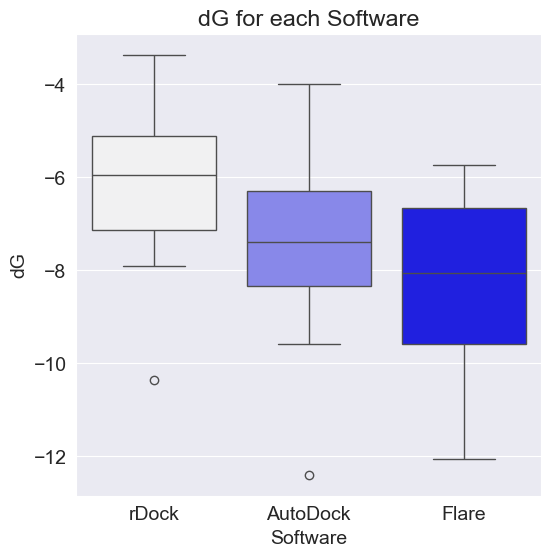

In [15]:
# Create the boxplot for dG
plt.figure(figsize=(6, 6))
# Set the default figure size
# plt.rcParams["figure.figsize"] = (6, 6)  # Adjust as needed

# Set the default font size
plt.rcParams.update({'font.size': 14})  # Adjust as needed
sns.boxplot(x='Software', y='dG', data=df_all, palette='light:b', hue='Software')
plt.title('dG for each Software')
plt.savefig('dG_boxplot.png')
plt.show()

<h1>Box & whisker plot for RMSD cross-software comparison</h1>

In [27]:
# loading RMSD data
df_rmsd_autodock = pd.read_csv('./data/RMSD/rmsd_autodock.csv')
df_rmsd_flare = pd.read_csv('./data/RMSD/rmsd_flare.csv')
df_rmsd_rdock = pd.read_csv('./data/RMSD/rmsd_rdock.csv')

In [28]:
def filter_rmsd(df):
    '''Filter RMSD data'''
    # i only want site 1 data
    df = df.loc[df['Site_Number'].isin(['Site1', 'Site 1'])]
    # Convert 'RMSD' column to numeric in each dataframe and handle non-numeric values
    df['RMSD Value'] = pd.to_numeric(df['RMSD Value'], errors='coerce')
    # Fill NaN values with a number that makes sense in your context, for example, 0
    df['RMSD Value'].fillna(0, inplace=True)
    # dropna
    df = df.dropna(subset=['RMSD Value'])
    df = df.dropna(subset=['Ligand_Name'])
    # cleaning up wrong ligand names, e.g. DAR should be DAR_DIR
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('DAR_DIR', 'DAR')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Forsythoside_E', 'Forsythoside')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Oryxylin_A', 'Oroxylin_A')
    df['Ligand_Name'] = df['Ligand_Name'].str.replace('Quercitin', 'Quercetin')
    # dropping known bad ligands, e.g. 'Disulfiram'
    drop_list = ['Disulfiram', 'VTRRT', 'Diammonium', 'Scutellarein', 'Beta', 'Theaflavin_Digallate', 'Quercetin', 'Baicalein', 'Baicalin', 'NHC', 'Torvoside_H', 'Lopinavir']
    df = df[~df['Ligand_Name'].str.contains('|'.join(drop_list))] 
    
    # double checking...
    # df = df.loc[(df['Site_Number'] == 'Site1') & (df['RMSD Value'] == 0) & ((df['With_Or_Without_Water'] == 'WOW') | (df['With_Or_Without_Water'] == 'Without_Water'))]
    return df

In [29]:
# filtering RMSD data
df_rmsd_autodock = filter_rmsd(df_rmsd_autodock)
df_rmsd_flare = filter_rmsd(df_rmsd_flare)
df_rmsd_rdock = filter_rmsd(df_rmsd_rdock)

C:\Users\ian16\AppData\Local\Temp\ipykernel_4100\3296610154.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RMSD Value'] = pd.to_numeric(df['RMSD Value'], errors='coerce')
C:\Users\ian16\AppData\Local\Temp\ipykernel_4100\3296610154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RMSD Value'].fillna(0, inplace=True)
C:\Users\ian16\AppData\Local\Temp\ipykernel_4100\3296610154.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [30]:
# shape for each dataframe
print(df_rmsd_autodock.shape)
print(df_rmsd_flare.shape)
print(df_rmsd_rdock.shape)

(176, 4)
(180, 4)
(92, 3)


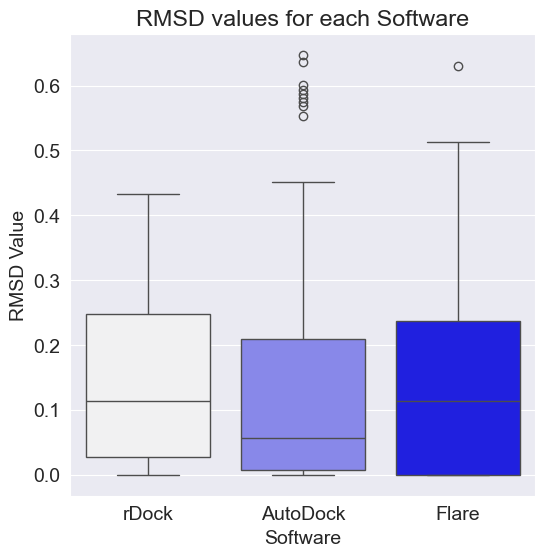

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to each dataframe to specify the software
df_rmsd_autodock['Software'] = 'AutoDock'
df_rmsd_flare['Software'] = 'Flare'
df_rmsd_rdock['Software'] = 'rDock'

# Concatenate the dataframes
df_all_rmsd = pd.concat([df_rmsd_rdock, df_rmsd_autodock, df_rmsd_flare])

# Create the boxplot
plt.figure(figsize=(6, 6))
# Set the default figure size
# plt.rcParams["figure.figsize"] = (6, 6)  # Adjust as needed

# Set the default font size
plt.rcParams.update({'font.size': 14})  # Adjust as needed
sns.boxplot(x='Software', y='RMSD Value', data=df_all_rmsd, palette= 'light:b', hue= 'Software')
plt.title('RMSD values for each Software')
plt.savefig('RMSD_boxplot.png')
plt.show()

In [32]:
# compute pearsons r for rmsd
r_rmsd_autodock_flare, _ = pearsonr(df_rmsd_autodock['RMSD Value'], df_rmsd_flare['RMSD Value'])
r_rmsd_autodock_rdock, _ = pearsonr(df_rmsd_autodock['RMSD Value'], df_rmsd_rdock['RMSD Value'])
r_rmsd_flare_rdock, _ = pearsonr(df_rmsd_flare['RMSD Value'], df_rmsd_rdock['RMSD Value'])

print(f"Pearson's R between AutoDock and Flare: {r_rmsd_autodock_flare}")
print(f"Pearson's R between AutoDock and rDock: {r_rmsd_autodock_rdock}")
print(f"Pearson's R between Flare and rDock: {r_rmsd_flare_rdock}")

ValueError: x and y must have the same length.

In [34]:
# Check if data is normally distributed
_, p_rmsd_autodock = stats.shapiro(df_rmsd_autodock['RMSD Value'])
_, p_rmsd_flare = stats.shapiro(df_rmsd_flare['RMSD Value'])
_, p_rmsd_rdock = stats.shapiro(df_rmsd_rdock['RMSD Value'])

print(f"Autodock p-value: {p_rmsd_autodock}")
print(f"Flare p-value: {p_rmsd_flare}")
print(f"rDock p-value: {p_rmsd_rdock}")

# If p-value is > 0.05, data is normally distributed
if p_rmsd_autodock > 0.05 and p_rmsd_flare > 0.05 and p_rmsd_rdock > 0.05:
        # Perform ANOVA
    _, p_value = stats.f_oneway(df_rmsd_autodock['RMSD Value'], df_rmsd_flare['RMSD Value'], df_rmsd_rdock['RMSD Value'])
    print(f"ANOVA p-value: {p_value}")
    
    # Compute independent t-test
    t_autodock_flare, p_autodock_flare = ttest_ind(df_rmsd_autodock['RMSD Value'], df_rmsd_flare['RMSD Value'])
    t_autodock_rdock, p_autodock_rdock = ttest_ind(df_rmsd_autodock['RMSD Value'], df_rmsd_rdock['RMSD Value'])
    t_flare_rdock, p_flare_rdock = ttest_ind(df_rmsd_flare['RMSD Value'], df_rmsd_rdock['RMSD Value'])
    
    print(f"Independent t-test between AutoDock and Flare: t = {t_autodock_flare}, p = {p_autodock_flare}")
    print(f"Independent t-test between AutoDock and rDock: t = {t_autodock_rdock}, p = {p_autodock_rdock}")
    print(f"Independent t-test between Flare and rDock: t = {t_flare_rdock}, p = {p_flare_rdock}")
else:
    # Pairwise comparison for AutoDock and Flare
    _, p_value = mannwhitneyu(df_rmsd_autodock['RMSD Value'], df_rmsd_flare['RMSD Value'])
    print(f"Mann-Whitney U test p-value between AutoDock and Flare: {p_value}")

    # Pairwise comparison for AutoDock and rDock
    _, p_value = mannwhitneyu(df_rmsd_autodock['RMSD Value'], df_rmsd_rdock['RMSD Value'])
    print(f"Mann-Whitney U test p-value between AutoDock and rDock: {p_value}")

    # Pairwise comparison for Flare and rDock
    _, p_value = mannwhitneyu(df_rmsd_flare['RMSD Value'], df_rmsd_rdock['RMSD Value'])
    print(f"Mann-Whitney U test p-value between Flare and rDock: {p_value}")

Autodock p-value: 1.5156280703675258e-14
Flare p-value: 7.153305031648571e-11
rDock p-value: 6.672721610812005e-06
Mann-Whitney U test p-value between AutoDock and Flare: 0.44401351050780813
Mann-Whitney U test p-value between AutoDock and rDock: 0.10387862609876806
Mann-Whitney U test p-value between Flare and rDock: 0.47476417867762155


In [14]:
# Create a dictionary with the statistical results
stats_results = {
    'Pair': ['AutoDock-Flare', 'AutoDock-rDock', 'Flare-rDock'],
    'Pearson R': [-0.07043977698862046, -0.402587142630647, -0.2051175809314156],
    'Independent t-test t-value': [1.579622778857505, -2.611077566022315, -4.3080279305811136],
    'Independent t-test p-value': [0.12135629053138279, 0.012295889389313327, 9.100191694049614e-05],
    'MSE': [6.862800434782609, 9.475551858847641, 10.92273460302851]
}

# Convert the dictionary to a DataFrame
df_stats_results = pd.DataFrame(stats_results)

df_stats_results

,Pair,Pearson R,Independent t-test t-value,Independent t-test p-value,MSE
0,AutoDock-Flare,-0.070440,1.579623,0.121356,6.862800
1,AutoDock-rDock,-0.402587,-2.611078,0.012296,9.475552
2,Flare-rDock,-0.205118,-4.308028,0.000091,10.922735


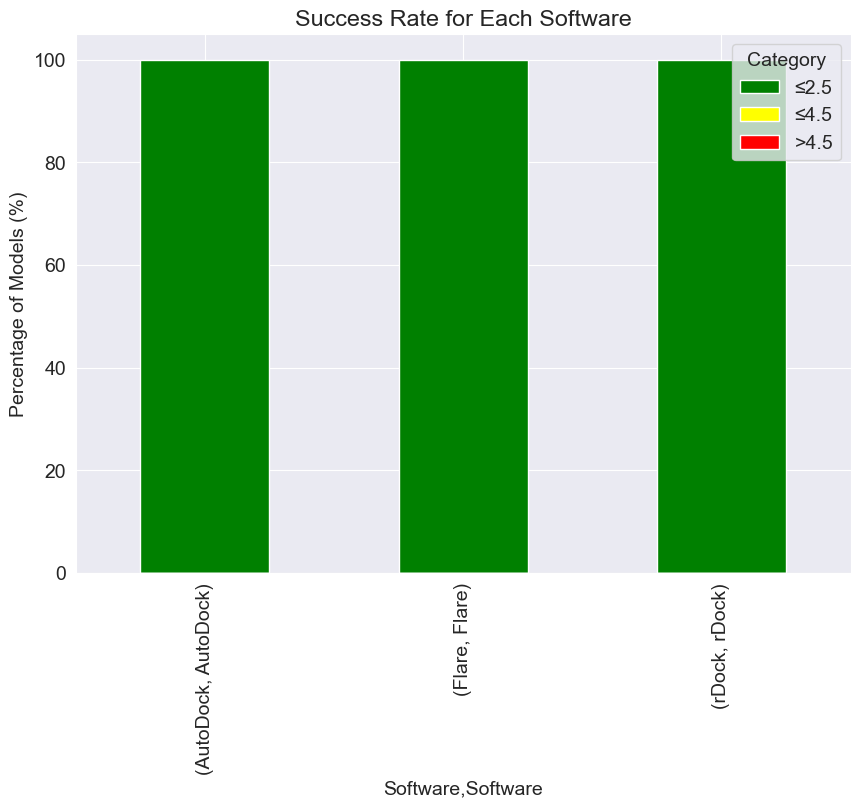

In [21]:
# Categorize RMSD values
df_all_rmsd['Category'] = pd.cut(df_all_rmsd['RMSD Value'], bins=[0, 2.5, 4.5, np.inf], labels=['≤2.5', '≤4.5', '>4.5'])

# Calculate the percentage of models in each category for each software
df_percentage = df_all_rmsd.groupby(['Software', 'Category']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

# Plot the stacked bar chart
df_percentage.plot(kind='bar', stacked=True, color=['green', 'yellow', 'red'], figsize=(10, 7))
plt.ylabel('Percentage of Models (%)')
plt.title('Success Rate for Each Software')
plt.show()